<center><img src="https://raw.githubusercontent.com/VolodymyrGavrysh/My_RoadMap_Data_Science/master/pictures/5F828D8129CBAFFB.jpg" width="400"></center>

<center><font size="6"><b>Heart Disease</b></font></center>

<center><font size="4"><b>Data set exploration</b></font></center>

***


**Motivation**

After struggling with the Data Science theory one need to practice it with real task and master his ability to apply variety of different tools and libraries

I have choisen well studed dataset of heart disease for two reason:
- small amount numerical data make it easy to condact experiments faster . 
- understandable features makes it easy to interpreted the results.
- it is possible to compare your results with well studied data

--------------------------------------------------

In the task we will investigate **Heart Disease Data Set** applying different ensemble learning technics.

This dataset provides information on the risk factors for
heart disease. The [original](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) database contains 76 attributes, but all published experiments refer to using a subset of 14 of thema and is refferenced as Cleveland dataset ([link](https://raw.githubusercontent.com/devrepublik/data-science-course/master/data/boosting/heart.csv)).

Experiments with the Cleveland database have concentrated on attempting to distinguish presence (value 1) or absence (value 0) of heart disease in the patient.

This is a typical **binary classification task.**

### Attribute Information:

> 1. **Age**: Age
> 2. **Sex**: Sex (1 = male; 0 = female)
> 3. **ChestPain**: Chest pain (typical, asymptotic, nonanginal, nontypical)
> 4. **RestBP**: Resting blood pressure
> 5. **Chol**: Serum cholestoral in mg/dl
> 6. **Fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
> 7. **RestECG**: Resting electrocardiographic results
> 8. **MaxHR**: Maximum heart rate achieved
> 9. **ExAng**: Exercise induced angina (1 = yes; 0 = no)
> 10. **Oldpeak**: ST depression induced by exercise relative to rest
> 11. **Slope**: Slope of the peak exercise ST segment
> 12. **Ca**: Number of major vessels colored by flourosopy (0 - 3)
> 13. **Thal**: (3 = normal; 6 = fixed defect; 7 = reversable defect)
> 14. **target**: AHD - Diagnosis of heart disease (1 = yes; 0 = no)

## Strategy

1. Short Data visualization. This task details the visualization aspect of the data analysis.
2. Data cleaning. This task relates to the data cleaning aspect of the analysis.
3. Insights generation. Analysis might leads to insights generation to generate unique and visually understandable insights.
4. Feature engineering. This task relates to the feature engineering aspect of the analysis.
5. Start analysis with Random Forest model. Compare than two simple model - decision tree and random forest.
6. Continue with AdaBoost model with selected features. Use Cross validation and explore partial effects of features on model.
7. Compare models results during Grid Search process. Find best performed model with best model parameters.
8. Conclusion.

## Evaluation method


Measurement of any model ability to generalize data requires a clear metric.

Here will use well-studied several metrics at the same time. In conclusion we may select the one that might be more important to some  observer.

Since we are limited with data (almost always), a part of it will be used to train the model (80%), and the rest of the data (20%) will be used solely to evaluate with mentioned metrics. 

More details here - "Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning" (https://arxiv.org/abs/1811.12808)

## Solution


In [68]:
### Libraries

import pandas as pd
import numpy as np
import time
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# https://matplotlib.org/
import matplotlib.pyplot as plt 

# https://seaborn.pydata.org/
import seaborn as sns 

# https://scikit-learn.org/stable/about.html#citing-scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC # support vector classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# catboost.ai
from catboost import CatBoostClassifier, Pool, cv

#https://xgboost.readthedocs.io/en/latest/index.html
import xgboost

### 1. Load dataset:

In [2]:
# Original ([link](https://raw.githubusercontent.com/devrepublik/data-science-course/master/data/boosting/heart.csv))
df = pd.read_csv('heart.csv') # check your path
display(df.head(2), 'Dataset is small with only {} observation'.format(df.shape[0]))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1


'Dataset is small with only 303 observation'

#### Check data types and missing values

In [3]:
assert df.dtypes.any() != object
df.isnull().values.any() # check if there are missing values 

False

There is only numerical features. No NaN. No missing values. Nice! )

## 2. Short Data visualization.

### Features correlation

In [4]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', low=0.15)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1,-0.0984466,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.0968008,0.210013,-0.168814,0.276326,0.0680014,-0.225439
sex,-0.0984466,1,-0.0493529,-0.0567688,-0.197912,0.0450318,-0.0581963,-0.0440199,0.141664,0.0960929,-0.0307106,0.118261,0.210041,-0.280937
cp,-0.068653,-0.0493529,1,0.0476078,-0.0769044,0.094444,0.0444206,0.295762,-0.39428,-0.14923,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.0567688,0.0476078,1,0.123174,0.177531,-0.114103,-0.0466977,0.0676161,0.193216,-0.121475,0.101389,0.0622099,-0.144931
chol,0.213678,-0.197912,-0.0769044,0.123174,1,0.0132936,-0.15104,-0.00993984,0.0670228,0.0539519,-0.00403777,0.0705109,0.098803,-0.0852391
fbs,0.121308,0.0450318,0.094444,0.177531,0.0132936,1,-0.0841891,-0.00856711,0.0256651,0.00574722,-0.0598942,0.137979,-0.0320193,-0.0280458
restecg,-0.116211,-0.0581963,0.0444206,-0.114103,-0.15104,-0.0841891,1,0.0441234,-0.0707329,-0.0587702,0.0930448,-0.0720424,-0.0119814,0.13723
thalach,-0.398522,-0.0440199,0.295762,-0.0466977,-0.00993984,-0.00856711,0.0441234,1,-0.378812,-0.344187,0.386784,-0.213177,-0.0964391,0.421741
exang,0.0968008,0.141664,-0.39428,0.0676161,0.0670228,0.0256651,-0.0707329,-0.378812,1,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.0960929,-0.14923,0.193216,0.0539519,0.00574722,-0.0587702,-0.344187,0.288223,1,-0.577537,0.222682,0.210244,-0.430696


#### Highly correlated features with target variable can increase error on new (unseen data), so we need to reduce their influence.

### Plot distribution of correlated features

<Figure size 432x288 with 0 Axes>

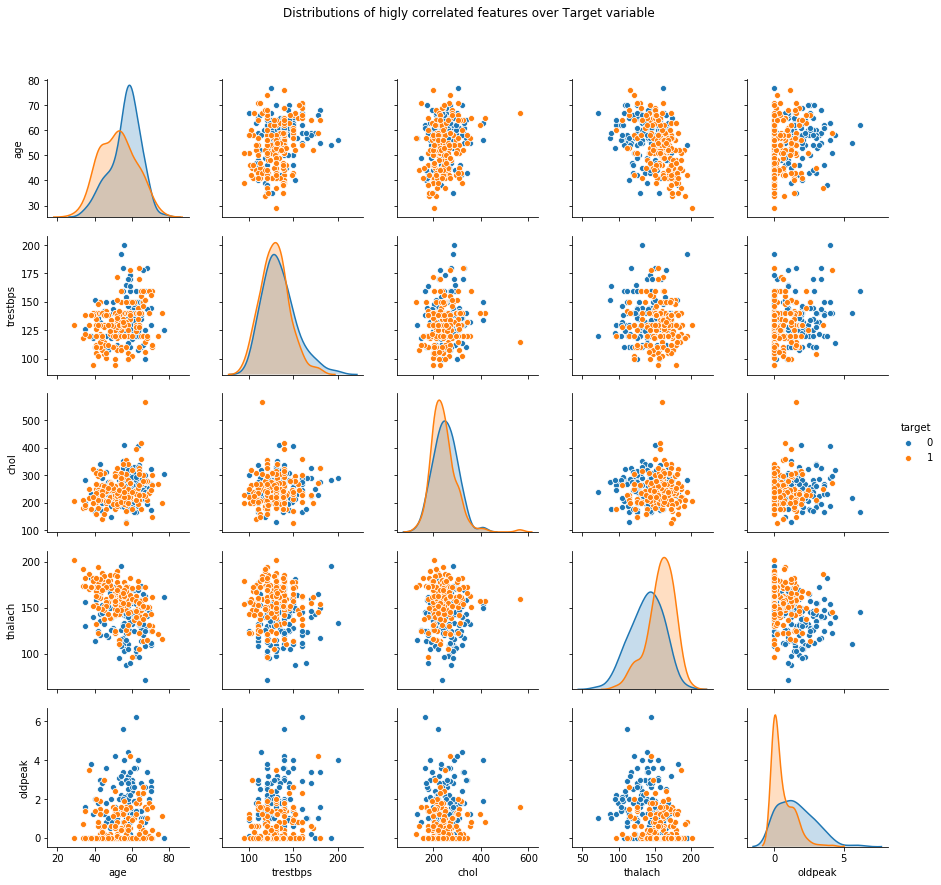

In [5]:
fig = plt.figure()
sns.pairplot(df, vars=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], hue='target')\
            .fig.suptitle('Distributions of higly correlated features over Target variable')
plt.subplots_adjust(top=0.9)
plt.show();

We can see that some data can be separated quite well (different colors for the target variable on the chart).
Here you can also see what distribution the correlating variables have - we will be interested in those that have different (not similar) boundaries.

### Explore distribution of target variable (ill and not ill) with Age, Sex and Level of Pain features.

<Figure size 720x720 with 0 Axes>

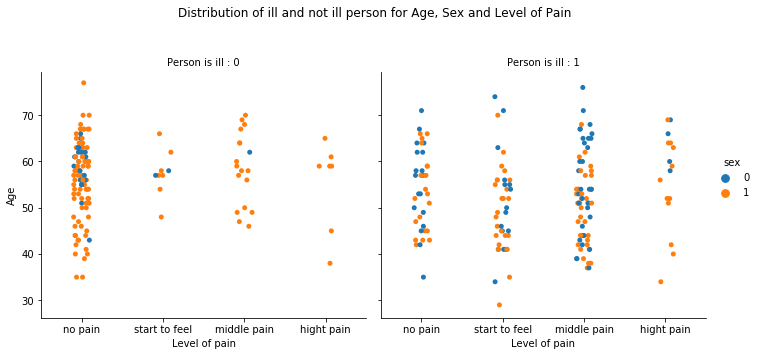

In [7]:
# plot 
fig = plt.figure(figsize=(10,10))
g = sns.catplot(x='cp', y='age', hue='sex', col='target', data=df)
(g.set_axis_labels("Level of pain", "Age")
 .set_xticklabels(["no pain", "start to feel", "middle pain", 'hight pain'])
 .set_titles("Person is ill : {col_name}")
 .fig.suptitle('Distribution of ill and not ill person for Age, Sex and Level of Pain'))
plt.subplots_adjust(top=0.8)
plt.show()

The graph gives us several ides about of the ***distribution of healthy and sick people, depending on age, gender and level of pain.***

We see that the ill group is more normal distributed by gender and density.

Medium pain is the most clear features, which, oddly enough, works for all ages.

We observe some less dense zones, but not many outlayres. And it is obvious that some groups contain very little data - for example, healthy people with severe pain.

### Age distribution 

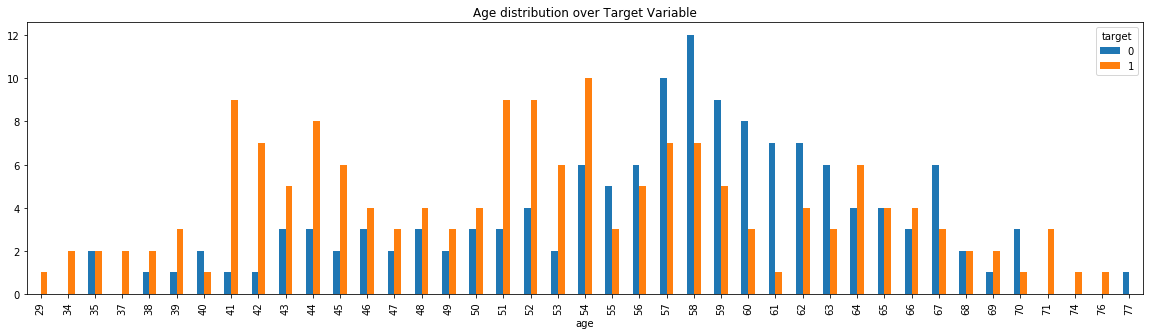

In [8]:
pd.crosstab(df.age, df.target).plot(kind='bar', figsize=(20, 5))
plt.title('Age distribution over Target Variable')
plt.show();

Two peaks of the disease:
41-46 years old and 51-54 years old
Maybe we can use it. For example, we can create a categorical variable.

## 3. Data cleaning, transforning

#### Check features that are not binary and nor normaly distrubuted

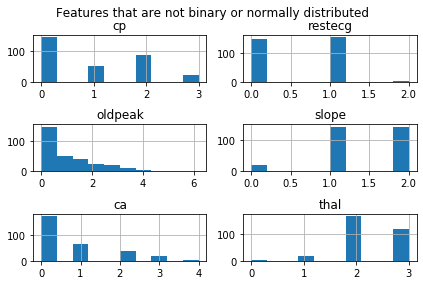

In [9]:
fig, axarr = plt.subplots(3, 2)
fig.suptitle("Features that are not binary or normally distributed", fontsize=12)
plt.subplot(3, 2, 1, title='cp')
df.cp.hist()
plt.subplot(3, 2, 2, title='restecg')
df.restecg.hist()
plt.subplot(3, 2, 3, title='oldpeak')
df.oldpeak.hist()
plt.subplot(3, 2, 4, title='slope')
df.slope.hist()
plt.subplot(3, 2, 5, title='ca')
df.ca.hist()
plt.subplot(3, 2, 6, title='thal')
df.thal.hist()
plt.subplots_adjust(top=1.5)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show();

So, let transfrom cp, restecg, oldpeak, slope, ca, thal features

In [10]:
# Function for One Hot for tranformation
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)
df = encode(df, df.cp)
df = encode(df, df.thal)
df = encode(df, df.slope)
df = encode(df, df.restecg)
df = encode(df, df.ca)
df.drop(['cp', 'thal', 'slope', 'restecg', 'ca'], axis=1, inplace=True)
df.head(2)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,slope_1,slope_2,restecg_0,restecg_1,restecg_2,ca_0,ca_1,ca_2,ca_3,ca_4
0,63,1,145,233,1,150,0,2.3,1,0,...,0,0,1,0,0,1,0,0,0,0
1,37,1,130,250,0,187,0,3.5,1,0,...,0,0,0,1,0,1,0,0,0,0


Check the numeric values 

In [11]:
df[['age', 'trestbps', 'chol', 'thalach']].describe()

,age,trestbps,chol,thalach
count,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865
std,9.082101,17.538143,51.830751,22.905161
min,29.000000,94.000000,126.000000,71.000000
25%,47.500000,120.000000,211.000000,133.500000
50%,55.000000,130.000000,240.000000,153.000000
75%,61.000000,140.000000,274.500000,166.000000
max,77.000000,200.000000,564.000000,202.000000


Scale these numeric values

In [12]:
scale = StandardScaler()
se = pd.DataFrame(scale.fit_transform(df[['age', 'trestbps', 'chol', 'thalach']]))

Prepare data for modeling

In [13]:
df = pd.concat([df, se], axis=1)
y = df.target 
df.drop(['target', 'age', 'trestbps', 'chol', 'thalach'], axis=1, inplace=True)
df.rename(columns={0: 'target', 1: 'age', 2:'trestbps', 3:'chol', 4:'thalach'}, inplace=True)
df.head(2)

,sex,fbs,exang,oldpeak,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,...,restecg_2,ca_0,ca_1,ca_2,ca_3,ca_4,target,age,trestbps,chol
0,1,1,0,2.3,0,0,0,1,0,1,...,0,1,0,0,0,0,0.952197,0.763956,-0.256334,0.015443
1,1,0,0,3.5,0,0,1,0,0,0,...,0,1,0,0,0,0,-1.915313,-0.092738,0.072199,1.633471


### 5.Feature engineering

Let us get rid of multicollinearity with target variable with PCA

In [14]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)

Check the optimal number of componets for PCA

In [15]:
total = 0
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    total += pca.explained_variance_ratio_[i]
print()
print('Total % of initial varianve {}'.format(total))

1 component: 26.74% of initial variance
2 component: 13.81% of initial variance
3 component: 10.91% of initial variance
4 component: 9.81% of initial variance
5 component: 6.36% of initial variance
6 component: 5.24% of initial variance
7 component: 5.18% of initial variance
8 component: 3.55% of initial variance
9 component: 3.28% of initial variance
10 component: 2.88% of initial variance

Total % of initial varianve 0.8775800114335135


**We select 10 PCA components to explane data variance**

#### What cross val score WITHOUT PCA (10 componets)?

In [16]:
# Check the RandomForestClassifier
cross_val_score(RandomForestClassifier(n_estimators=50, random_state=11), df, y, scoring='roc_auc').mean()

0.9017917267917268

In [17]:
# Check the LogisticRegression
cross_val_score(LogisticRegression(random_state=11), df, y, scoring='roc_auc').mean()

0.9181417348084014

#### What cross val score WITH PCA (10 componets)?

In [18]:
cross_val_score(RandomForestClassifier(n_estimators=50, random_state=11), df_pca, y, scoring='roc_auc').mean()

0.8991101491101492

In [19]:
cross_val_score(LogisticRegression(random_state=11), df_pca, y, scoring='roc_auc').mean()

0.9201298701298702

RandomForestClassifier give us a bit worst result. LogisticRegression small improvement.

Since there is not much data, it is likely that the transformation of the PCA will negatively affect the final results.

Let's look at other ways to select (or delete) features. Especially collinear ones.

### Check the variance of features without PCA - with sklearn tools

In [20]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

Let use Threshold (75%) to reduce number of feature variance

In [21]:
df_variance = VarianceThreshold(0.75).fit_transform(df)
display('from {} features we have {}'.format(df.shape[1], df_variance.shape[1]))

'from 27 features we have 5'

We can use other SelectKBest with AVONA stat classifier and top 5 features

In [22]:
df_best_5 = SelectKBest(f_classif, k=5).fit_transform(df, y)

Let chectk how PCA will change the performance

In [23]:
df_pca_variance = VarianceThreshold(.075).fit_transform(df_pca)

**See the results**

In [24]:
cv_df = cross_val_score(RandomForestClassifier(n_estimators=50, random_state=11), df, y, scoring='roc_auc').mean()
cv_var_5 = cross_val_score(RandomForestClassifier(n_estimators=50, random_state=11), df_best_5, y, scoring='roc_auc').mean()
cv_var_75 = cross_val_score(RandomForestClassifier(n_estimators=50, random_state=11), df_variance, y, scoring='roc_auc').mean()
cv_pca = cross_val_score(RandomForestClassifier(n_estimators=50, random_state=11), df_pca_variance, y, scoring='roc_auc').mean()

In [25]:
print('------------------------')
display('Initial CV score {}'.format(cv_df))
display('CV score with 5 best features with SelectKBest sklearn class {}'.format(cv_var_5))
display('CV score with Threshold (75%) using VarianceThreshold sklearn class {}'.format(cv_var_75))
display('CV score on PCA tranformed data with Threshold (75%) using VarianceThreshold sklearn class {}'.format(cv_pca))
print('------------------------')

------------------------


'Initial CV score 0.9017917267917268'

'CV score with 5 best features with SelectKBest sklearn class 0.9010942760942762'

'CV score with Threshold (75%) using VarianceThreshold sklearn class 0.7501362834696168'

'CV score on PCA tranformed data with Threshold (75%) using VarianceThreshold sklearn class 0.8991101491101492'

------------------------


The initial value of 1 is due to the small amount of data. 

And we can say that PSA and a feature reduction by the threshold of 0.75 does not increase or even worsens the results.

Select seems to do better. But a small amount of data allows us to use it fully.

**So we are going to work with a full set of features.**

And final test of our hypothesis we use one more solution.

### Use Feature selection tool to check our hypothesis

In [26]:
#http://rasbt.github.io/mlxtend/
from mlxtend.feature_selection import SequentialFeatureSelector
# Split data
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.2)
display('total {} features now'.format(X_train.shape[1]))

'total 27 features now'

Start selector RandomForestClassifier. You can change verbose to 2, just to see how roc_auc changes

In [27]:
selector = SequentialFeatureSelector(RandomForestClassifier(random_state=11), scoring='roc_auc', 
                                     verbose=0,  k_features=10, forward=True, n_jobs=-1)
selector.fit(X_train, y_train) # train selector

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=RandomForestClassifier(bootstrap=True,
                                                           ccp_alpha=0.0,
                                                           class_weight=None,
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
 

Here is results. We can use just 9 features (out of 14) to get value of roc_auc - 0.93

In [29]:
display('features idx {}, features name {}, max score {}'.format(selector.k_feature_idx_, selector.k_feature_names_, selector.k_score_))

"features idx (0, 4, 9, 12, 13, 17, 21, 22, 25, 26), features name ('sex', 'cp_0', 'thal_1', 'slope_0', 'slope_1', 'restecg_2', 'ca_3', 'ca_4', 'trestbps', 'chol'), max score 0.9303571428571429"

Once again - 303 observation is not enought to use such approach to reduce noise (via feature reduction or transformation).

So I propose to **use whole data set.** Even feature engineering in such a case will affect the accuracy of classification on new data.

But for accurate reliability and applying a scientific approach to experiments - we will save the date set with a reduced number of features (10 out of 14)

In [30]:
df_less_features = df[list(selector.k_feature_names_)]
df_less_features.shape

(303, 10)

### 5 Use a random forest and LogisticRegression for Feature Importance

We would like to see first look on feature importance rank

In [31]:
random_forest = RandomForestClassifier(n_estimators=50, max_features=2, random_state=11, verbose=False).fit(X_train, y_train)
logreg = LogisticRegression(random_state=11, verbose=False).fit(X_train, y_train)

#### Plot graph of features importance 

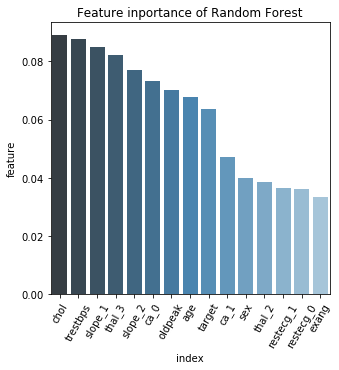

'ROC_AUC is 0.8582551339589284'

In [32]:
def plot_features_importance(model, X_train, X_test, y_test):
    ddd = pd.DataFrame(model.feature_importances_, X_train.columns, columns=["feature"])
    ddd = ddd.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[5,5])
    sns.barplot(x='index', y='feature', data=ddd[:15], palette="Blues_d")
    plt.title('Feature inportance of Random Forest')
    plt.xticks(rotation=60)
    plt.show();
    display('ROC_AUC is {}'.format(roc_auc_score(y_test, random_forest.predict_proba(X_test)[:,1])))
    
# run function
plot_features_importance(random_forest, X_train, X_test, y_test)

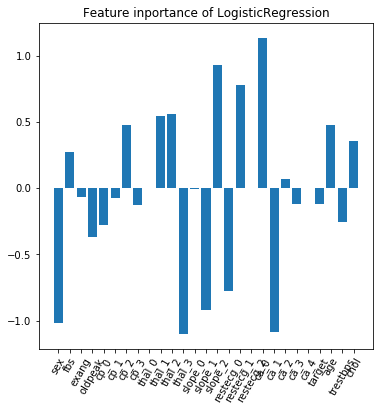

In [33]:
# Plot 
plt.figure(figsize=(6,6))
plt.bar(X_train.columns, logreg.coef_[0])
plt.title('Feature inportance of LogisticRegression')
plt.xticks(rotation=60)
plt.show();

We can use LogisticRegression coefs to see 'influence' of features.

Random_forest and LogisticRegression see data differently. LogisticRegression is more about linear relations, while random_forest catch non-linear as well.

For example, cp_0 feature at random_forest model is 2th, while for logreg it is negative! At the same time ca_0 in both models are number 1. Check age as well. 

Such insights help to understand which features has more linear or non-linear processes. (in certain point it is mixture of them)

Although, for me all possible ways to use these differences are not yet available - I'm sure they can be useful for analyzing more complex data. 

This can give confidence, for example, in the **choice of transformation methods at the date cleaning stage.**


#### Let see how many estinators random_forest needs for best performance

100%|██████████| 39/39 [00:07<00:00,  4.93it/s]


'max oob 0.8333333333333334 and number of estimators 115'

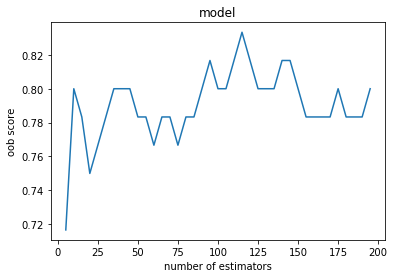

In [34]:
def graph(model, X_train, y_train):
    obb = []
    est = list(range(5, 200, 5))
    for i in tqdm(est):
        random_forest = model(n_estimators=i, random_state=11,max_features=2,
                                           verbose=0, oob_score=True, n_jobs=-1)
        random_forest.fit(X_train, y_train)
        obb.append(random_forest.oob_score_)
        
    display('max oob {} and number of estimators {}'.format(max(obb), est[np.argmax(obb)]))
    plt.plot(est, obb)
    plt.title('model')
    plt.xlabel('number of estimators')
    plt.ylabel('oob score')
    plt.show();
    
graph(RandomForestClassifier, X_train, y_train)

#### I used OOB score (out-of-bag) as more stable statistic for trees that better track Trees estimator performance. 

We see that **80 estimators** is enought for best score.

More about OOB https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

### Compare decision tree and the random forest by checking performances `ROC` metrics

In [35]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])

0.6065891472868217

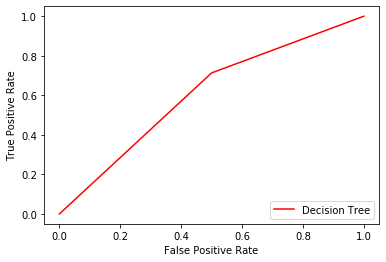

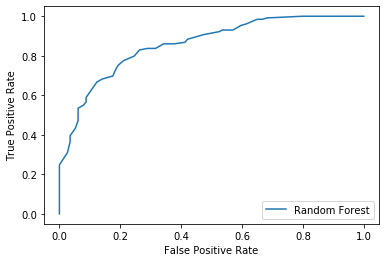

In [36]:
plot_roc_curve(dt, X_test, y_test, c='r', label='Decision Tree')
plot_roc_curve(random_forest, X_test, y_test, label='Random Forest')
plt.show();

Here you can clearly see how the random forest more accurately describes (line is more flexible with bigger total square) the data, with more **than 0.90 ROC_AUC score**

### 6. Let us play with more advanced model - `AdaBoost`. We consider the variables `Thal`, `Sex`, `ChestPain` and Chol`

We want to compare how such algoritm perform with limited data comparing to more simple one with complite dataset


In [37]:
X_t, Xt, y_t, yt = train_test_split(df[['thal_0', 'thal_1', 'thal_2', 'thal_3', 'sex', 'cp_0', 'cp_1', 'cp_2', 'cp_3']], y)

In [38]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=11)
adaboost.fit(X_t, y_t)

roc_auc_score(yt, adaboost.predict_proba(Xt)[:,1])

0.9239583333333334

Wow! Just with 9 features (selected rather randomly) we have huge score improvement 

#### Can we do better? Let us use GridSearch


In [39]:
# Parameters 
param_grid = [{'n_estimators' : list(range(25, 150, 25))
              }]
cv = StratifiedKFold(random_state=11)

In [40]:
adaboost_1 = AdaBoostClassifier(random_state=11)
grid = RandomizedSearchCV(adaboost_1, param_distributions=param_grid, scoring='roc_auc', cv=cv)

In [41]:
grid.fit(X_t, y_t)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=False),
                   error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=11),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{'n_estimators': [25, 50, 75, 100,
                                                          125]}],
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [42]:
grid.best_estimator_, grid.best_params_, grid.best_score_

(AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=25, random_state=11),
 {'n_estimators': 25},
 0.8131142857142859)

In [43]:
cv = cross_val_score(grid.best_estimator_, X_t, y_t, scoring='roc_auc', cv=5)
display('CV score is {}'.format(np.mean(cv)))

'CV score is 0.8131142857142859'

**The results are less!**

An example of how complex algorithms on small data can behave unstably.


### Let the partial effects for the previous subset of variables (thal_0', 'thal_1', 'thal_2', 'thal_3', 'sex', 'cp_0', 'cp_1', 'cp_2', 'cp_3)

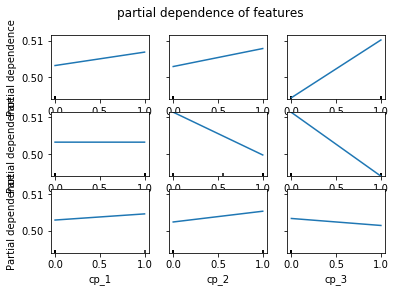

In [44]:
# save features
features = list(X_t.columns)
# plot 
plot_partial_dependence(grid.best_estimator_, X_t, features,
                        n_jobs=3, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('partial dependence of features ')
fig.subplots_adjust(hspace=0.2)
plt.show();

Partial dependence plots show the dependence between the target function 2 and a set of ‘target’ features, marginalizing over the values of all other features (the complement features). 
https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

Here we see two strong dependence (a linear relationship). People get ill with thal_2 feature (top left). cp_0 (no chest pain) says that they are not ill at all.

thal_0', 'thal_1' - week dependences but with small positive rate. all others are not dependent.

### 7. Calculate and compare models (linear, boosting and others) with and without feature reduction

Metrics are:

- Mean squared error
- Prediction accuracy
- ROC_AUC

In [50]:
'''To get same results you need run it two times. 
First time with df X_train, X_test, y_train, y_test = train_test_split(df, y) 
get the results df dataset with 27 features.

Second time 
X_train, X_test, y_train, y_test = train_test_split(df_less_features, y)
get result for df_less_features with 10 features'''

X_train, X_test, y_train, y_test = train_test_split(df, y)
df_less_features.shape, df.shape

((303, 10), (303, 27))

In [51]:
n_jobs = -1
random_state = 11 

### Pipeline

pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, n_jobs=n_jobs))])

pipe_ada = Pipeline([('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=random_state))])

pipe_gbc = Pipeline([('gbc', GradientBoostingClassifier(random_state=random_state))])

pipe_ext = Pipeline([('ext', ExtraTreesClassifier(random_state=random_state, n_jobs=n_jobs))])

pipe_cat = Pipeline([('cat', CatBoostClassifier(random_state=random_state, verbose=False))])

pipe_bag = Pipeline([('bag', BaggingClassifier(n_jobs=n_jobs, random_state=random_state))])

pipe_svc = Pipeline([('svc', SVC(random_state=random_state, probability=True))])

pipe_xgb = Pipeline([('xgb', xgboost.XGBClassifier(n_jobs=n_jobs, random_state=random_state))])

### params

cv = StratifiedKFold(shuffle=False, n_splits=5, random_state=11)

grid_params_rf = [{
                'rf__criterion': ['entropy', 'gini'],
                'rf__min_samples_leaf': [10, 15, 20],
                'rf__max_depth': [10, 15, 20],
                'rf__n_estimators' : list(range(40, 120, 20))
                }]

grid_params_ada = [{
                'ada__learning_rate' : [0.5, 0.8, 1],
                'ada__n_estimators': [25, 50]
                }]

grid_params_gbc = [{
                'gbc__learning_rate' : list(np.linspace(0.01, 0.5, 5))
                }]

grid_params_ext = [{
                'ext__min_samples_leaf': [15, 18, 20],
                'ext__max_depth': [10, 15, 16],
                'ext__n_estimators' : [50, 100, 150]
                }]

grid_params_cat = [{
                'cat__learning_rate' : [0.003, 0.004],
                'cat__iterations': [1000]
    
                }]

grid_params_bag = [{'bag__base_estimator': [KNeighborsClassifier()],
                'bag__n_estimators': [50, 70, 80] #list(range(10, 80, 10))
                    }]

grid_params_svc = [{
                    'svc__C': [1, 3, 4]
                    }]

grid_params_xgb = [{
                'xgb__booster': ['gbtree', 'gblinear'],
                'xgb__max_depth': list(range(3,15,3)),
                'xgb__learning_rate': list(np.linspace(0.1, 0.9, 3)),
                'xgb__n_estimators': list(range(100, 300, 100)),
                'xgb__min_child_weight': list(range(1,6,2)),
                'xgb__eta': [0.2, 0.3]
                }]

### RandomizedSearchCV

gs_rf = RandomizedSearchCV(pipe_rf, param_distributions=grid_params_rf,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_ada = RandomizedSearchCV(pipe_ada, param_distributions=grid_params_ada,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_gbc = RandomizedSearchCV(pipe_gbc, param_distributions=grid_params_gbc,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_ext = RandomizedSearchCV(pipe_ext, param_distributions=grid_params_ext,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_cat = RandomizedSearchCV(pipe_cat, param_distributions=grid_params_cat,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_bag = RandomizedSearchCV(pipe_bag, param_distributions=grid_params_bag,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_svc = RandomizedSearchCV(pipe_svc, param_distributions=grid_params_svc,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=grid_params_xgb,
                     scoring='roc_auc', cv=cv, n_iter=15)

### Dict of models
look_for = [gs_rf, gs_ada, gs_gbc, gs_ext, gs_cat, gs_bag, gs_svc, gs_xgb]

model_dict = {0:'RandomForest', 1: 'Adaboost', 2: "Gradient boost", 3:'ExtraTreeBoost', 4: 'Catboost', 5:'Bagging', \
             6:'SupportVEctorClass', 7:'Xgb'}

In [52]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
result_auc = {}
mse = {}
models = []
# iterate over models 
for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test, y_test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc
        mse[index] = mean_squared_error(y_test, model.predict(X_test))     


+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForest
---------------------------------------------
best params {'rf__n_estimators': 60, 'rf__min_samples_leaf': 10, 'rf__max_depth': 20, 'rf__criterion': 'gini'}
best score is 0.9227142857142857
---------------------------------------------
ROC_AUC is 0.897815362931642 and accuracy rate is 0.897815362931642
It lasted for 15.704 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Adaboost
---------------------------------------------
best params {'ada__n_estimators': 25, 'ada__learning_rate': 0.5}
best score is 0.7351666666666666
---------------------------------------------
ROC_AUC is 0.7427766032417196 and accuracy rate is 0.7427766032417196
It lasted for 0.151 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Gradient boost
---------------------------------------------
best params {'gbc__lear

In [60]:
# func to show results

def model_performance(df, result_acc, result_auc, mse, model_dict):
    result = pd.DataFrame([result_acc, result_auc, mse])
    result.columns = list(model_dict.values())
    result.index = ['accouracy', 'roc_auc', 'MSE']
    display(result.head(), 'shape of data is {}'.format(df.shape))
    plt.figure(figsize=(8,8))
    plt.plot(result.columns.values, result.iloc[0,:].values, label=['accouracy'])
    plt.plot(result.columns.values, result.iloc[1,:].values, label=['roc_auc'])
    plt.plot(result.columns.values, result.iloc[2,:].values, label=['mse'])

    plt.xticks(rotation=60)
    plt.title('Compare performance')
    plt.legend()
    plt.show()

def plot_ExtraTreesClassifier():
    extra_tree = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=15, max_depth=15).fit(df, y)

    temp_df = pd.DataFrame(df.columns, extra_tree.feature_importances_, columns=['feature']).reset_index().sort_values(by='index', ascending=False)
    temp_df.columns = ['Feature_importance', 'Feature']

    plt.bar(temp_df[:7].Feature, temp_df[:7].Feature_importance)
    plt.xticks(rotation=60)
    plt.title('Feature_importance')
    plt.show();

### Results WITHOUT feature reduction. Here we use 27 features.

,RandomForest,Adaboost,Gradient boost,ExtraTreeBoost,Catboost,Bagging,SupportVEctorClass,Xgb
accouracy,0.922714,0.735167,0.899810,0.919619,0.919333,0.900532,0.905587,0.906238
roc_auc,0.897815,0.742777,0.832981,0.903453,0.888654,0.865751,0.887245,0.849190
MSE,0.171053,0.263158,0.236842,0.197368,0.171053,0.223684,0.210526,0.223684


'shape of data is (303, 27)'

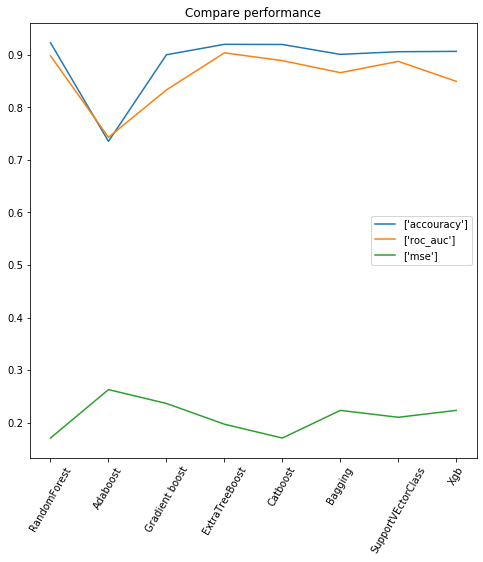

In [53]:
model_performance(df, result_acc, result_auc, mse, model_dict)

### Results WITH feature reduction. Here we use 10 features. See above how df_less_features was generated.

,RandomForest,Adaboost,Gradient boost,ExtraTreeBoost,Catboost,Bagging,SupportVEctorClass,Xgb
accouracy,0.838229,0.663333,0.798686,0.855210,0.821505,0.821371,0.814133,0.821200
roc_auc,0.870139,0.737500,0.851042,0.891667,0.887500,0.877778,0.875000,0.870486
MSE,0.184211,0.263158,0.223684,0.250000,0.184211,0.197368,0.157895,0.184211


'shape of data is (303, 10)'

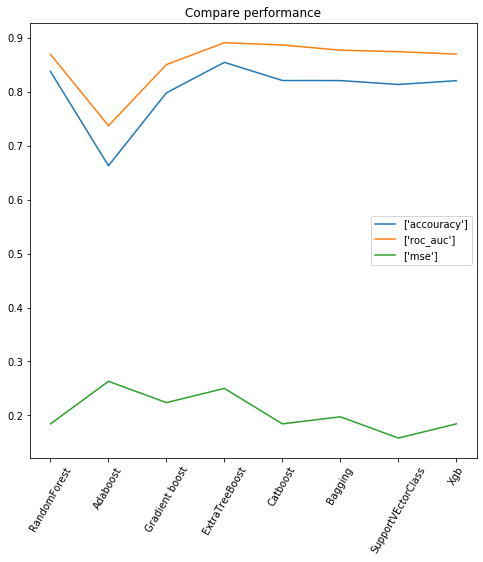

In [49]:
model_performance(df_less_features, result_acc, result_auc, mse, model_dict)

## 8. Conclusion

### General overview:

### 1 Here are most important factors that influence on heart disease in any age or affect any gender

* Chest Pain
* Fixed defect or heart without defect
* Number of vessels
* Exercise induced angina
* Slopes of the peak exercise ST segment (more about https://www.sciencedirect.com/science/article/abs/pii/0002870386902656)


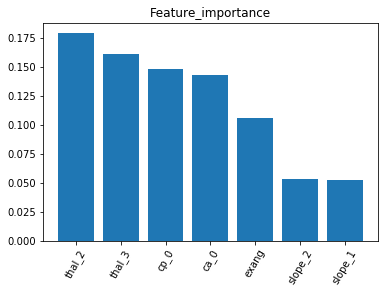

In [63]:
plot_ExtraTreesClassifier()

### 2 With additional data record (person profile data) it is possible to predict illness with more than 90% accuracy

Almost all models showed quite good results.

* As expected, models built on ensembles were able to accurately determine non-linear relationships.

* Processing speed fast enough to use personal computers.

* Reducing the variables from 27 to 10 did not significantly affect the result, which may reduce the cost (time) of diagnosing patients.

* conducted EDA (see p 1) allow clearly articulate a risk group by age, gender and other characteristics

### 3 Metrics and evaluation models.

The presented metrics evaluate different approaches of models in the process of data evaluation.

The choice of them, accordingly, *** will depend on the priorities of management ***, which set priorities.

For example, if we assume that erros in classification for a healthy person is less significant (Type I error) than erros in classification of a patient, then the appropriate metric would be ***Precision.***

About Precision https://en.wikipedia.org/wiki/Precision_and_recall#Precision

Here is additionally about metrics https://en.wikipedia.org/wiki/Receiver_operating_characteristic

### 4 How to use results and models?

Such studies can help with early diagnosis of diseases, helping to reduce the risk of complications.

Also modeling can be used by other specialists in the medical field without the high cost of IT infrastructure with acceptable accuracy and speed.

Naturally, this modeling can be used by a wider circle: patients, insurance companies, researchers etc.

-------------------------------------

Thank you for your time! I will be glad to hear your comments or questions.
Gavrysh Volodymyr https://www.linkedin.com/in/volodymyrgavrish/
email: vladimir101175@gmail.com

Attribution 4.0 International (CC BY 4.0)